In [1]:
import pandas as pd
import numpy as np
from pydlm import dlm, trend, seasonality, dynamic, autoReg, longSeason
import matplotlib.pyplot as plt



ModuleNotFoundError: No module named 'pydlm'

In [ ]:
df = pd.read_csv('C:\\Users\\Admin\\Downloads\\ACB.csv')
df

,Date,Close,Open,High,Low,Volume,% Change
0,25/12/2023,"23,350.00","23,250.00","23,450.00","23,200.00","758,000,000.00",0.65%
1,22/12/2023,"23,200.00","23,200.00","23,300.00","23,200.00","451,000,000.00",-0.22%
2,21/12/2023,"23,250.00","23,200.00","23,250.00","23,050.00","708,000,000.00",0.22%
3,20/12/2023,"23,200.00","23,050.00","23,250.00","23,050.00","886,000,000.00",0.65%
4,19/12/2023,"23,050.00","22,800.00","23,100.00","22,800.00","1,147,000,000.00",1.10%
...,...,...,...,...,...,...,...
1486,8/1/2018,"12,004.60","11,615.40","12,004.60","11,615.40","1,296,000,000.00",3.35%
1487,5/1/2018,"11,615.40","11,675.30","11,825.00","11,495.70","2,156,000,000.00",0.00%
1488,4/1/2018,"11,615.40","11,585.50","11,645.30","11,495.70","2,126,000,000.00",0.26%
1489,3/1/2018,"11,585.50","11,615.40","11,705.20","11,375.90","1,689,000,000.00",-0.26%


In [ ]:

df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df.sort_values('Date', inplace=True)

In [ ]:

df['Close'] = df['Close'].str.replace(',', '').astype(float)


In [ ]:

train_size = int(len(df) * 0.7)
train_data, test_data = df[:train_size], df[train_size:]

In [ ]:
y_train = train_data['Close'].values


In [ ]:
myDLM = dlm(y_train)
# Thêm mô hình linear trend
myDLM = myDLM + trend(degree=1, discount=0.99, name='linear_trend')
# Thêm mô hình seasonality với chu kỳ 7 ngày
myDLM = myDLM + seasonality(7, name='7day_seasonality')
myDLM = myDLM + autoReg(degree=1, w=1)


In [ ]:
myDLM.fit()

Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.


In [ ]:
(predictTrainMean, _) = myDLM.predictN(N=train_size)
(predictTestMean, _) = myDLM.predictN(N=len(test_data))
(predictNext30Mean, _) = myDLM.predictN(N=len(df) + 30)

In [ ]:
(predictMean, predictVar) = myDLM.predictN(N=len(test_data))
test_dates = test_data['Date']
y_test = test_data['Close'].values
mae = np.mean(np.abs(predictMean - y_test))
mape = np.mean(np.abs((predictMean - y_test) / y_test)) * 100
rmse = np.sqrt(np.mean((predictMean - y_test) ** 2))
print(f'MAE: {mae:.2f}')
print(f'MAPE: {mape:.2f}%')
print(f'RMSE: {rmse:.2f}')

MAE: 7565.44
MAPE: 33.34%
RMSE: 8441.15


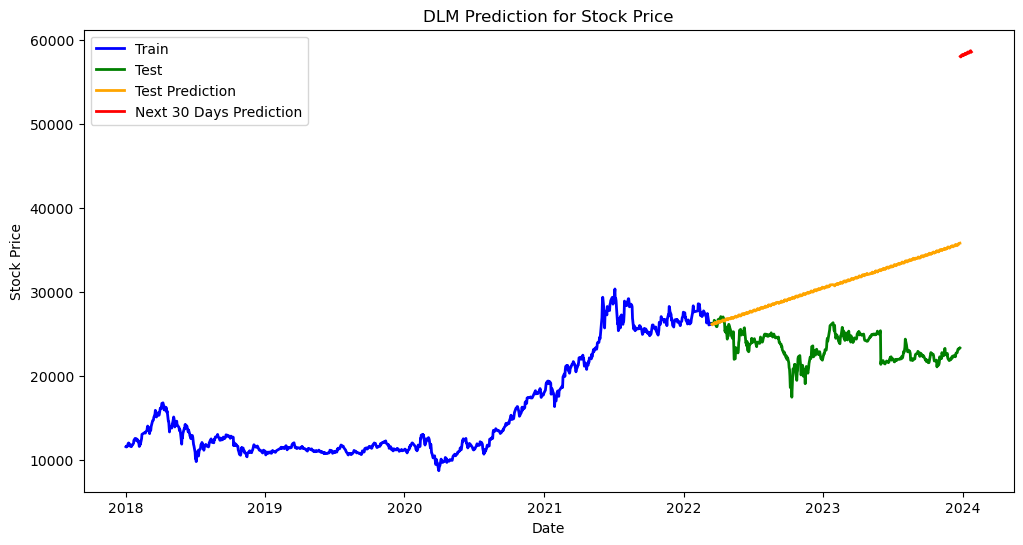

In [ ]:
plt.figure(figsize=(12, 6))
all_dates = df['Date']

plt.plot(all_dates[:train_size], df['Close'][:train_size], label='Train', linewidth=2, color='blue')

# Vẽ phần test
plt.plot(all_dates[train_size:], df['Close'][train_size:], label='Test', linewidth=2, color='green')

# Vẽ dự đoán cho phần test
plt.plot(all_dates[train_size:], predictTestMean, label='Test Prediction', linewidth=2, color='orange')

# Vẽ dự đoán cho next 30 days
next_30_dates = pd.date_range(start=df['Date'].max() + pd.DateOffset(days=1), periods=30, freq='D')
plt.plot(next_30_dates, predictNext30Mean[-30:], label='Next 30 Days Prediction', linewidth=2, color='red')

plt.title('DLM Prediction for Stock Price')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()